In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import and_, or_, not_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
## query the date of last data point
last_date_query = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
## transform date into datetime
last_date = datetime.strptime(last_date_query[0], '%Y-%m-%d')

# calculate query date
## get to the last year
query_date = datetime(last_date.year - 1, last_date.month, last_date.day)
## to include the end points, use "day-1"
query_date = query_date - timedelta(days=1)

# Perform a query to retrieve the data and precipitation scores
last_12months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(last_12months, columns=['date', 'prcp']).set_index('date')
df_prcp = df_prcp.sort_values('date')

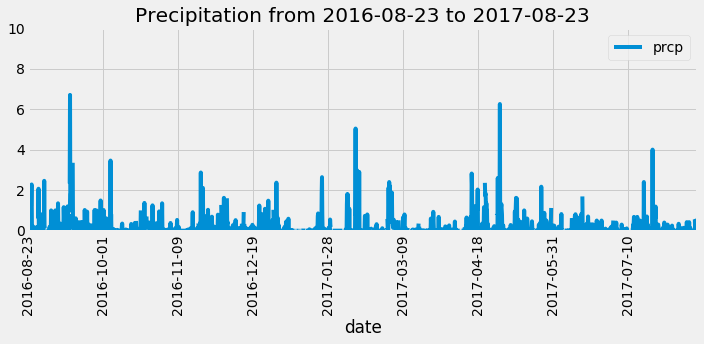

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
## inserted benchmark dates to get a sense of when the observation took place.
df_prcp.plot(figsize = (10,5), title = "Precipitation from 2016-08-23 to 2017-08-23", grid = True)
plt.xticks (rotation=90)
plt.ylim (0, 10)
plt.tight_layout()
plt.savefig("Outputs/Precipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [13]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.station).count()
number_of_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station = station_activity[0][0]
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

m_active_stats = session.query(*sel).\
    filter(Measurement.station == most_active_station).all()

m_active_stats

[(54.0, 85.0, 71.66378066378067)]

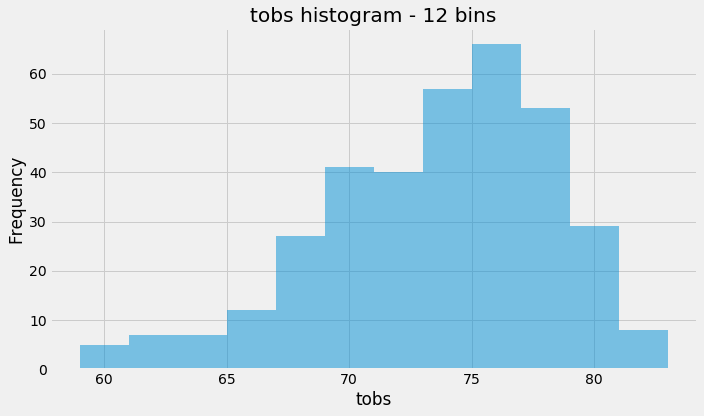

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activestation_12months = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.date > query_date).\
    filter(Measurement.station == most_active_station).all()

df_station = pd.DataFrame(activestation_12months, columns=['station', 'date', 'tobs'])

plt.figure(figsize = (10,6))
plt.title("tobs histogram - 12 bins")
plt.xlabel('tobs')
df_station["tobs"].plot.hist(bins = 12, alpha = 0.5)
plt.tight_layout()
plt.savefig("Outputs/Tobs Histogram.png")
plt.show()

## Optional Challenge Assignment

### Temperature Analysis I

In [17]:
# * Hawaii is reputed to enjoy mild weather all year. 
# Is there a meaningful difference between the temperature in, for example, June and December?
# * Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

#Query June and December Temperature
session = Session(engine)
sel = [Measurement.date, func.avg(Measurement.tobs)]
avg_june_temps = session.query(*sel).filter(func.strftime("%m", Measurement.date) == '06').group_by(Measurement.date).all()
avg_dec_temps = session.query(*sel).filter(func.strftime("%m", Measurement.date) == '12').group_by(Measurement.date).all()
session.close()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_june_temp = pd.DataFrame(avg_june_temps, columns=['date', 'avg_temp'])
df_dec_temp = pd.DataFrame(avg_dec_temps, columns=['date', 'avg_temp'])
df_june_temp = df_june_temp.sort_values('date')
df_dec_temp = df_dec_temp.sort_values('date')

#save the day of month
df_june_temp["dayofmonth_injune"] = df_june_temp["date"].agg(lambda x: x.split("-")[2])
df_dec_temp["dayofmonth_indec"] = df_dec_temp["date"].agg(lambda x: x.split("-")[2])

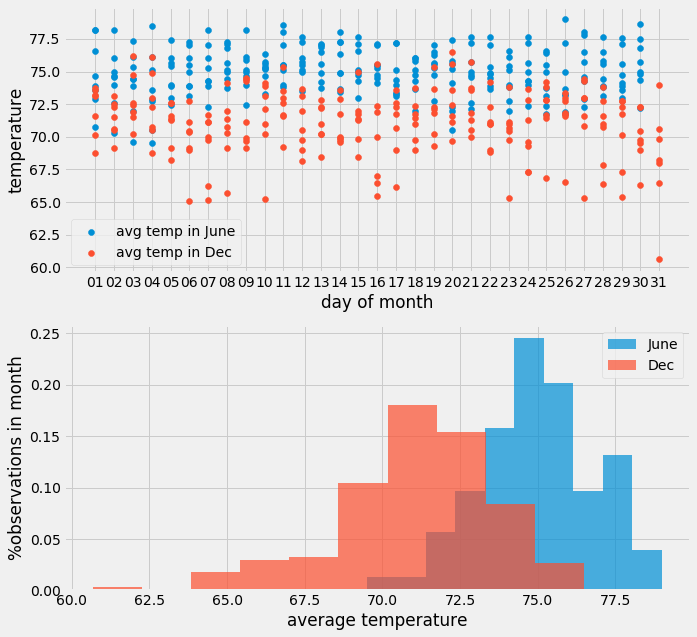

In [18]:
# Scatter Plot of Data
plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.scatter(df_june_temp["dayofmonth_injune"], df_june_temp['avg_temp'], label="avg temp in June")
plt.scatter(df_dec_temp["dayofmonth_indec"], df_dec_temp['avg_temp'], label="avg temp in Dec")
plt.xlabel("day of month")
plt.ylabel("temperature")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(df_june_temp["avg_temp"], 10, density=True, alpha=0.7, label="June")
plt.hist(df_dec_temp['avg_temp'], 10, density=True, alpha=0.7, label="Dec")
plt.xlabel("average temperature")
plt.ylabel("%observations in month")
plt.legend() 

plt.savefig("Outputs/June vs Dec")
plt.show()

In [19]:
# * Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Use independent t-test: comparing the means of 2 independent samples - temperature in June vs. Decemeber.
stats.ttest_ind(df_june_temp['avg_temp'], df_dec_temp['avg_temp'], equal_var=False)

#P-value is <= .05 so the temperature differences are statistically significant.
#We cannot reject the null that there is no difference between average temperature between June and December.

Ttest_indResult(statistic=19.02480906571998, pvalue=1.2522889413943713e-57)

### Temperature Analysis II

In [20]:
#Initiate Trip Date:
trip_start = '2018-01-01'
trip_end = '2018-01-10'

#transform to query dates
query_start = datetime.strptime(trip_start, '%Y-%m-%d')
query_start = datetime(query_start.year - 1, query_start.month, query_start.day)
query_end = datetime.strptime(trip_end, '%Y-%m-%d')
query_end = datetime(query_end.year - 1, query_end.month, query_end.day)

query_start, query_end

(datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 10, 0, 0))

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps(query_start, query_end))

[(60.0, 67.89090909090909, 77.0)]


In [22]:
#my trip dates will be from 2018-01-01 to 201801-10
mycalc_temps = calc_temps(query_start, query_end)
list_results = list(np.ravel(mycalc_temps))

min_temp = list_results[0]
avg_temp = list_results[1]
max_temp = list_results[2]

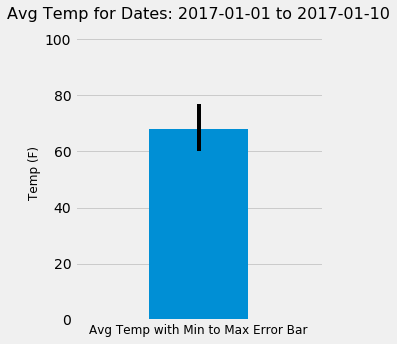

In [23]:
lower_error = avg_temp - min_temp
upper_error = max_temp - avg_temp

asymmetric_error = [lower_error, upper_error]

plt.figure(figsize=(5,5))
plt.bar(1, avg_temp, yerr = [[lower_error], [upper_error]])

plt.xlim(0,2)
plt.xticks ([],[])
plt.ylim(0,105)
plt.title('Avg Temp for Dates: 2017-01-01 to 2017-01-10', fontsize = 16)
plt.xlabel("Avg Temp with Min to Max Error Bar", fontsize = 12)
plt.ylabel('Temp (F)', fontsize = 12)

plt.tight_layout()
plt.savefig("Outputs/Trip Avg Temp.png")
plt.show()

### Temperature Analysis III

In [24]:
### * Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.
query_start, query_end

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

query = session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= query_start).\
    filter(Measurement.date <= query_end).group_by(Station.station).order_by(Measurement.prcp.desc()).all()

# Perform a query to retrieve the data and precipitation scores
query

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.16999999999999998),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.6),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Use the start and end date to create a range of dates
query_start, query_end

# Stip off the year and save a list of %m-%d strings
querydateswithyear = pd.date_range(query_start, query_end).strftime('%Y-%m-%d').tolist()
querydates = pd.date_range(query_start, query_end).strftime('%m-%d').tolist()

mydateswithyear = pd.date_range(trip_start, trip_end).strftime('%Y-%m-%d').tolist()

for day in querydates:
    normals.append(daily_normals(day)[0])

# Loop through the list of %m-%d strings and calculate the normals for each date
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0)]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_mytrip = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df_mytrip['query_date'] = querydateswithyear
df_mytrip['my_vacation_dates'] = mydateswithyear
df_mytrip = df_mytrip.set_index('my_vacation_dates')
df_mytrip

,tmin,tavg,tmax,query_date
my_vacation_dates,,,,
2018-01-01,62.0,69.153846,77.0,2017-01-01
2018-01-02,60.0,69.396226,77.0,2017-01-02
2018-01-03,62.0,68.909091,77.0,2017-01-03
2018-01-04,58.0,70.000000,76.0,2017-01-04
2018-01-05,56.0,67.964286,76.0,2017-01-05
2018-01-06,61.0,68.964912,76.0,2017-01-06
2018-01-07,57.0,68.543860,76.0,2017-01-07
2018-01-08,57.0,67.160714,75.0,2017-01-08
2018-01-09,58.0,67.929825,78.0,2017-01-09


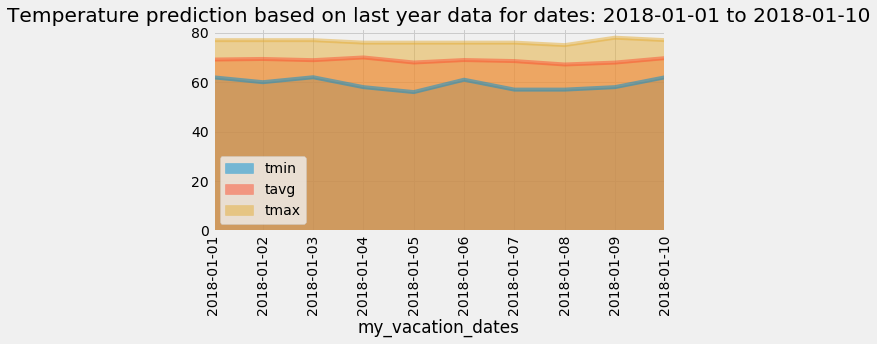

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
df_mytrip.plot.area(figsize = (10,5), title = "Temperature prediction based on last year data for dates: 2018-01-01 to 2018-01-10", stacked = False, alpha = 0.5)
plt.xticks (rotation=90)
plt.tight_layout()
plt.savefig("Outputs/stacked plot of temperatures.png")
plt.show()